In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pityingrofl","key":"9003ec9be136a33b6f65b19b9f70769e"}'}

# Download X-ray Pneumonia Dataset

In [2]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download x-ray pneumonia dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 96% 2.21G/2.29G [00:20<00:02, 38.7MB/s]
100% 2.29G/2.29G [00:20<00:00, 120MB/s] 


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Preprocessing and Data Loaders

In [4]:
base_dir = 'chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if len(os.listdir(val_dir)) == 0:
    for cls in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
        files = os.listdir(os.path.join(train_dir, cls))
        val_size = int(0.1 * len(files))
        val_files = np.random.choice(files, val_size, replace=False)
        for f in val_files:
            os.rename(os.path.join(train_dir, cls, f), os.path.join(val_dir, cls, f))

In [5]:
# data generators
IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.


In [6]:
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 16 images belonging to 2 classes.


In [7]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


# Build & Train ConvNet

In [8]:
def build_model():
    model = models.Sequential([
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [9]:
model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 414ms/step - accuracy: 0.7294 - loss: 0.5547 - val_accuracy: 0.7500 - val_loss: 0.6013
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 408ms/step - accuracy: 0.8678 - loss: 0.3119 - val_accuracy: 0.8125 - val_loss: 0.5645
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 410ms/step - accuracy: 0.8817 - loss: 0.2783 - val_accuracy: 0.6875 - val_loss: 1.0319
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 408ms/step - accuracy: 0.9049 - loss: 0.2267 - val_accuracy: 0.7500 - val_loss: 0.9382
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 405ms/step - accuracy: 0.9112 - loss: 0.2114 - val_accuracy: 0.8125 - val_loss: 0.5686
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 404ms/step - accuracy: 0.9145 - loss: 0.1940 - val_accuracy: 0.8125 - val_loss: 0.4817
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 406ms/step - accuracy: 0.9285 - loss: 0.1841 - val_accuracy: 0.9375 - val_loss: 0.3973
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 400ms/step - accuracy: 0.9254 - loss: 0

# Evaluate & Plot Metrics

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.6483 - loss: 0.8699
Test Accuracy: 0.8013


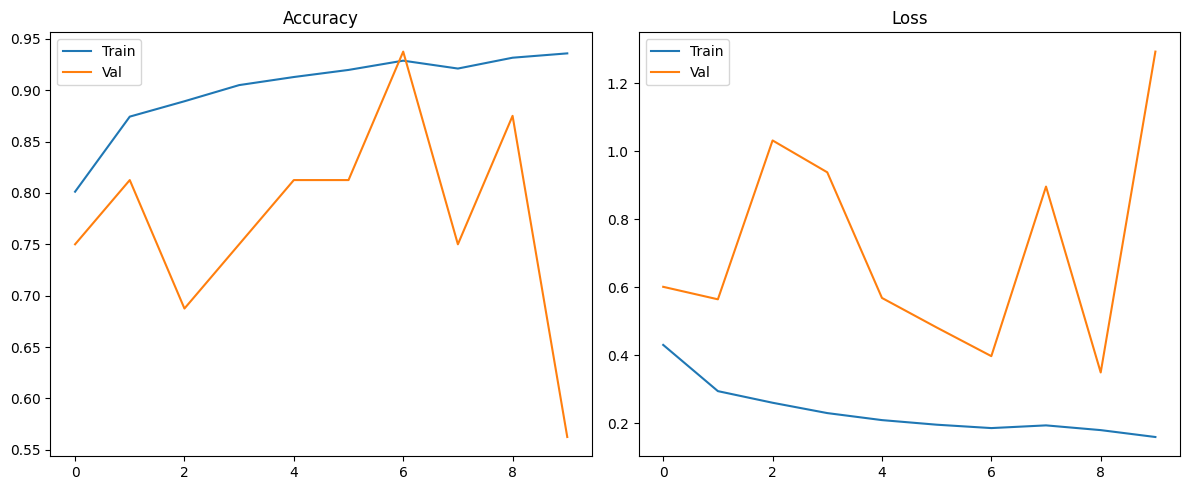

In [11]:
# evaluate on test data
loss, acc = model.evaluate(test_gen)
print(f"Test Accuracy: {acc:.4f}")

# plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Val")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Visualize Predictions

In [12]:
def show_predictions(model, generator, class_names, num_images=6):
    images, labels = next(generator)
    preds = model.predict(images[:num_images]) > 0.5
    labels = labels[:num_images].astype(int)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        color = 'green' if preds[i] == labels[i] else 'red'
        plt.title(f"Pred: {class_names[int(preds[i])]} | True: {class_names[labels[i]]}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step


<ipython-input-12-700e837f2c21>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Pred: {class_names[int(preds[i])]} | True: {class_names[labels[i]]}", color=color)


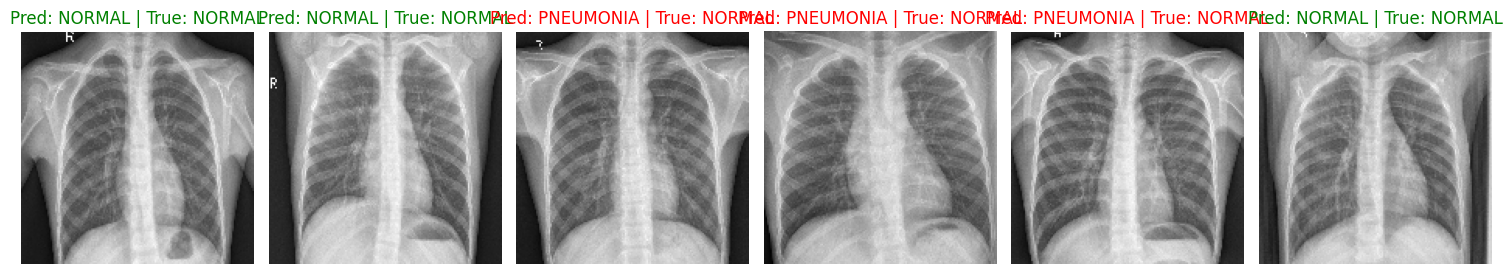

In [13]:
show_predictions(model, test_gen, ['NORMAL', 'PNEUMONIA'])

# Classification Report

In [14]:
test_gen.reset()
y_true = test_gen.classes
y_pred = (model.predict(test_gen) > 0.5).astype(int).flatten()

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step


In [15]:
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.95      0.50      0.65       234
   PNEUMONIA       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.76       624
weighted avg       0.83      0.80      0.78       624



# Save the Model

In [16]:
model.save("xray_pneumonia_model.h5")
print("model saved as xray_pneumonia_model.h5")

model saved as xray_pneumonia_model.h5
